# Pose Estimation: Comparing Googles 3 Primary Models 
Pose estimation is ann extremely relevant method in todays field that was developed for identifying and tracking human body parts frame by frame. Ultimately, the goal of pose estimation is to configure a "stick figure" that represents a human body, and then be able to classify the *pose* that the human is making (ie. sitting vs. standing, running vs. walking, etc.).  After some thurough research into the current state-of-the-art technology in development today, we discovered that 3 main models within Google's TensorFlowHub, are used almost exclusively to execute pose estimation tasks given their generalizability and sheer accuracy of the models. TensorFlowHub, is basically a GitHub-like service that Google hosts that is full of opensource models. This alone was an exciting discovery to learn that in industry/practice this would be a great resource to save you time developing models that someone has already done well! Jackson and Simon both also find high value in familiarizing ourselves with the current state-of-the-art implementation practices so we gain necessary skills for our futures. Familiarizing ourselves with these google models and having implemented them serves that exact purpose! We then will analize and compare our results and to see if we can confirm the conclusions that the theory of the models makes in Googles published overviews of each model (cited at the end of this notebook.

The 3 pose estimation CNN models in TensorFlowHub are multipose lightning, singlepose lightning, and singlepose thunder. For all three models, the program will be trying to find the location and the connectivity of 17 body parts that may or may not be in the pictureframe: nose, left eye, right eye, left ear, right ear, left shoulder, right shoulder, left elbow, right elbow, left wrist, right wrist, left hip, right hip, left knee, right knee, left ankle, and right ankle. Below we have created thurough explainations of the guts of each model (according to the content Google has been willing to release) with enough informtion to decifer when one would chose to use each model, and we have implemented each of these ourselves using documentation and examples in order to compare their performances. Within our implementations, we have used simple functions from OpenCV to gain access to the computer's webcam to perform real-time pose estimation on our viewer. 

#### If you wish to run this code yourself to see the webcame performance, run the following line for the necessary packages. Otherwise, there is a screen recording in this repo with how it performs on our computer. 

In [1]:
!pip install tensorflow-hub opencv-python matplotlib

In [2]:
import tensorflow as tf
import tensorflow_hub as hub
import cv2
from matplotlib import pyplot as plt
import numpy as np

In [3]:
# Optional to run if you are using a GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

# Multipose Lightning
As indicated by the name, this CNN model is able to detect and estimate up to 6 personnel at a time rather than one. The training set used for development was the COCO Keypoint Dataset Validation Set 2017, which is a dataset of 5k images of humans striking different poses in different backgrounds. The program can run at >30FPS on most modern laptops while tracking multiple humans and achieving good performance. The architecture of the model includes MobileNetV2 image feature extractor with Feature Pyramid Network decoder (to stride of 4) followed by CenterNet prediction heads with custom post-processing logic. According to the "model card" found in the documentation, the model has a "depth multiplier" of 1.5. Specifically this model is designed to be robust on detecting fitness/fast movement with motion blur poses. It is most suitable for detecting the pose of multiple people who are 3ft ~ 6ft away from and tracking for lower confidence scores. However, this model sacrifices speed of computation. 

In [4]:
#code documentation provides to upload the  Google TF model
model = hub.load('https://tfhub.dev/google/movenet/multipose/lightning/1')
movenet = model.signatures['serving_default']

In [5]:
def draw_keypoints(frame, keypoints, confidence_threshold):
    '''
        Draw points of 17 key features from the TF model overlayed onto the photo.
    '''
    y, x, c = frame.shape
    shaped = np.squeeze(np.multiply(keypoints, [y,x,1]))
    
    for kp in shaped:
        ky, kx, kp_conf = kp
        if kp_conf > confidence_threshold:
            cv2.circle(frame, (int(kx), int(ky)), 6, (0,255,0), -1)

In [6]:
EDGES = { #What joints connect to others ie wrist->elbow etc. 
    (0, 1): 'm',
    (0, 2): 'c',
    (1, 3): 'm',
    (2, 4): 'c',
    (0, 5): 'm',
    (0, 6): 'c',
    (5, 7): 'm',
    (7, 9): 'm',
    (6, 8): 'c',
    (8, 10): 'c',
    (5, 6): 'y',
    (5, 11): 'm',
    (6, 12): 'c',
    (11, 12): 'y',
    (11, 13): 'm',
    (13, 15): 'm',
    (12, 14): 'c',
    (14, 16): 'c'
}

In [7]:
# Function to loop through each person in the frame detected and render calling above functions 
def loop_through_people(frame, keypoints_with_scores, edges, confidence_threshold):
    for person in keypoints_with_scores:
        draw_connections(frame, person, edges, confidence_threshold)
        draw_keypoints(frame, person, confidence_threshold)
    return

In [8]:
def draw_connections(frame, keypoints, edges, confidence_threshold):
    y, x, c = frame.shape
    shaped = np.squeeze(np.multiply(keypoints, [y,x,1]))
    
    for edge, color in edges.items():
        p1, p2 = edge
        y1, x1, c1 = shaped[p1]
        y2, x2, c2 = shaped[p2]
        
        if (c1 > confidence_threshold) & (c2 > confidence_threshold):      
            cv2.line(frame, (int(x1), int(y1)), (int(x2), int(y2)), (0,0,255), 4)

### Implementation of multipose lightning
Below we are first implementing this multipose lighning model from TensorFlowHub by using image data from our webcam! This is setup with a while loop that basically specifies while a picture fram exists, execute movenet (which is the model we downloaded). To quit the tracking, hit the keyboard letter q. 

[[0.5811686  0.57216007 0.66454303]
 [0.5625025  0.58327323 0.7261058 ]
 [0.56838626 0.55912876 0.69999814]
 [0.57599586 0.6010885  0.5782689 ]
 [0.58514774 0.5444882  0.73948836]
 [0.69625825 0.6390013  0.62173945]
 [0.6899694  0.5161506  0.73533744]
 [0.8520705  0.6908042  0.6016554 ]
 [0.84688044 0.4623542  0.60741997]
 [0.9455348  0.7241607  0.5608837 ]
 [0.92960435 0.44108337 0.547267  ]
 [0.9613596  0.618431   0.34901804]
 [0.9619439  0.53974295 0.4609626 ]
 [0.9393101  0.7015738  0.08380537]
 [0.9445634  0.53329813 0.02738978]
 [0.9501301  0.58877313 0.00853537]
 [0.9552786  0.64472586 0.02812195]]


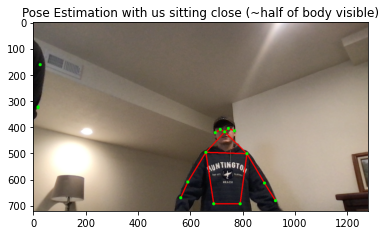

In [9]:
plt.figure()
cap = cv2.VideoCapture(1)
vec00=[]
count1=0
while cap.isOpened():
    count1=count1+1
    ret, frame = cap.read()
    
    # Resize image to multiple of 32
    img = frame.copy()
    img = tf.image.resize_with_pad(tf.expand_dims(img, axis=0), 160,256)
    input_img = tf.cast(img, dtype=tf.int32)
    
    # Detection section
    results = movenet(input_img)
    #print(results) #This is one set of detections 
    #print(results['output_0'].numpy()[:,:,:51])
    keypoints_with_scores = results['output_0'].numpy()[:,:,:51].reshape((6,17,3))

    
    # Render keypoints 
    loop_through_people(frame, keypoints_with_scores, EDGES, 0.1)
    
    cv2.imshow('Movenet Multipose', frame)
    vec0=keypoints_with_scores[0,:,2] 
    #plt.plot(vec0,'b')
    vec00.append(vec0)
    if cv2.waitKey(1) & 0xFF==ord('q'):
        break
cap.release()
cv2.waitKey(1)
cv2.destroyAllWindows()
cv2.waitKey(1)
plt.imshow(cv2.cvtColor(frame,cv2.COLOR_BGR2RGB))
plt.title('Pose Estimation with us sitting close (~half of body visible)')
vec0=keypoints_with_scores[0,:,2] 
print(keypoints_with_scores[0])
#Notice that the bottom half keypoint scores are lower because its the bottom of my body

With the performance of this Pose Estimation (can be seen in the last column of the above table, visually in the photorenduring of the estimation, or in our comparitive results shown later in this notebook) we can see that the confidnece values are falling off when classifying body features below our chest/waist. For reference, the above table shows the normalized x,y location of the body part, and then the confidence that the program has accurately identified the body-part and its location. The low confidence values here make logical sense because we are so close to the camera, it cannot see our lower half!

[[0.0811348  0.58834565 0.63556194]
 [0.06201142 0.5997207  0.16854668]
 [0.06228079 0.5723383  0.19885449]
 [0.07394571 0.6123209  0.44828963]
 [0.0831266  0.5499907  0.5991272 ]
 [0.22064832 0.63503635 0.8369226 ]
 [0.20873526 0.5316299  0.77622896]
 [0.36447746 0.66192436 0.8525142 ]
 [0.35173756 0.48475137 0.63275945]
 [0.4256114  0.7017622  0.7037336 ]
 [0.31656033 0.45823288 0.7156389 ]
 [0.52723974 0.6196634  0.86711377]
 [0.52768445 0.55410826 0.86501026]
 [0.7623859  0.6094104  0.6422529 ]
 [0.758789   0.5667706  0.6237755 ]
 [0.92182535 0.5928136  0.62924945]
 [0.9233991  0.5695197  0.64807653]]


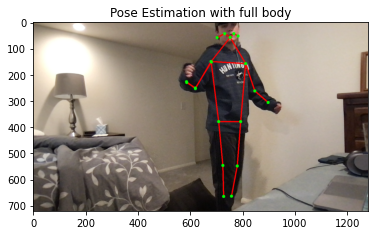

In [10]:
plt.figure()
cap = cv2.VideoCapture(1)
vec01=[]
count1=0
while cap.isOpened():
    count1=count1+1
    ret, frame = cap.read()
    
    # Resize image to multiple of 32
    img = frame.copy()
    img = tf.image.resize_with_pad(tf.expand_dims(img, axis=0), 160,256)
    input_img = tf.cast(img, dtype=tf.int32)
    
    # Detection section
    results = movenet(input_img)
    #print(results) #This is one set of detections 
    #print(results['output_0'].numpy()[:,:,:51])
    keypoints_with_scores = results['output_0'].numpy()[:,:,:51].reshape((6,17,3))

    
    # Render keypoints 
    loop_through_people(frame, keypoints_with_scores, EDGES, 0.1)
    
    cv2.imshow('Movenet Multipose', frame)
    vec0=keypoints_with_scores[0,:,2] 
    #plt.plot(vec0,'b')
    vec00.append(vec0)
    if cv2.waitKey(1) & 0xFF==ord('q'):
        break
cap.release()
cv2.waitKey(1)
cv2.destroyAllWindows()
cv2.waitKey(1)
plt.imshow(cv2.cvtColor(frame,cv2.COLOR_BGR2RGB))
plt.title('Pose Estimation with full body')
vec0=keypoints_with_scores[0,:,2] 
print(keypoints_with_scores[0])
#Notice that the bottom half keypoint scores are lower because its the bottom of my body

Now it is depicted far more confident about its estimation values for the lower half of our body aswell!

### Implementing multipose lightning onto TikTok 

To emphasize the programs to track quick and swift movements, we have applied Google's TF multipose lightning onto a compilation of popular tiktoks. Later in this notebook, or possible for next report (depending on our time constraints) this would be a good application of the pose estimation where we could identify and track the movements of body parts. Then if we investigated the difference between sets of two frames (very similar to what we have done in our optical flow investigation) we could train a classifier to identify what iconic tiktok dance is being performed. We don't know for sure (neither of us are avid tiktokers nor do we know the ins and outs of the algorithms behind the popular media app), but we assume that this feature would be edging on the real functionality behind TikToks highly acredited algorithms that can identify the type of video (ie the type of dance) and then recommend the video to the users that have shown the most positive responses to that type of video. 

[[0.42272973 0.54600745 0.5619725 ]
 [0.40676445 0.5923161  0.7474092 ]
 [0.39032745 0.5129808  0.5593801 ]
 [0.43830037 0.6125744  0.77069634]
 [0.40492326 0.43557897 0.70326513]
 [0.56050026 0.6791682  0.8041794 ]
 [0.5815418  0.265283   0.8158042 ]
 [0.66480637 0.8670517  0.7317036 ]
 [0.8086784  0.20564881 0.79593235]
 [0.57405865 0.8452248  0.75382906]
 [0.9750048  0.05488274 0.16048633]
 [0.9533889  0.6270398  0.7446866 ]
 [0.9639043  0.36242592 0.84429395]
 [1.0097271  0.6940333  0.01188238]
 [0.98335844 0.3059272  0.00536906]
 [0.9724536  0.44756457 0.04915537]
 [0.9812056  0.6296454  0.04822564]]


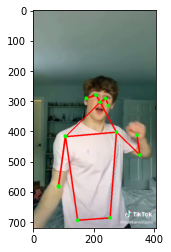

In [11]:
cap = cv2.VideoCapture('tictok.mp4')
while cap.isOpened():
    ret, frame = cap.read()
    
    # Resize image to multiple of 32
    img = frame.copy()
    img = tf.image.resize_with_pad(tf.expand_dims(img, axis=0), 256,160)
    input_img = tf.cast(img, dtype=tf.int32)
    
    # Detection section
    results = movenet(input_img)
    #print(results) #This is one set of detections 
    #print(results['output_0'].numpy()[:,:,:51])
    keypoints_with_scores = results['output_0'].numpy()[:,:,:51].reshape((6,17,3))

    
    # Render keypoints 
    loop_through_people(frame, keypoints_with_scores, EDGES, 0.3)
    
    cv2.imshow('Movenet Multipose', frame)
    
    if cv2.waitKey(1) & 0xFF==ord('q'):
        break
cap.release()
cv2.waitKey(1)
cv2.destroyAllWindows()
cv2.waitKey(1)
plt.imshow(cv2.cvtColor(frame,cv2.COLOR_BGR2RGB))
print(keypoints_with_scores[0]) 


In [12]:
frame.shape #1080 1920

(720, 406, 3)

## Implementing TF Singlepose Thunder with webcam

Using a very similar approach, but instead integrating Googles TensorFlowHub Singlepose Thunder CNN model, we have performed similar pose estimation through real-time webcam video, but this only tracks one human at at time for simpler comparison (less variablility in our comparison results). This is a higher capacity model that performs better predictionc quality while still achieving real-time (>30FPS) speed with a reported depth muyltiplier of 1.75. It is expected that singlepose thunder will lag behind the singlepose lightning, but it will have more confident predictions. 

In [13]:
##### NOW DOING AGAIN WITH NEW MODEL
model = hub.load("https://tfhub.dev/google/movenet/singlepose/thunder/4")
movenet = model.signatures['serving_default']

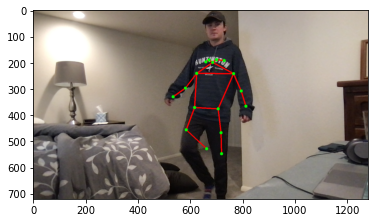

In [14]:
cap = cv2.VideoCapture(1)
vec11=[]
count2=0
while cap.isOpened():
    count2=count2+1
    ret, frame = cap.read()
    
    # Resize image to multiple of 32
    img = frame.copy()
    img = tf.image.resize_with_pad(tf.expand_dims(img, axis=0), 256,256)
    input_img = tf.cast(img, dtype=tf.int32)
    
    # Detection section
    results = movenet(input_img)
    #print(results) #This is one set of detections 
    #print(results['output_0'].numpy()[:,:,:51])
    keypoints_with_scores = results['output_0'].numpy()[:,:,:51].reshape((1,17,3))

    
    # Render keypoints 
    loop_through_people(frame, keypoints_with_scores, EDGES, 0.1)
    
    cv2.imshow('Movenet Multipose', frame)
    vec1=keypoints_with_scores[0,:,2] 
    #plt.plot(vec1,'g')
    vec11.append(vec1)
    if cv2.waitKey(1) & 0xFF==ord('q'):
        break
cap.release()
cv2.waitKey(1)
cv2.destroyAllWindows()
cv2.waitKey(1)
plt.imshow(cv2.cvtColor(frame,cv2.COLOR_BGR2RGB))

Comment on the error: As you can see in the video recording and this snipped above, there is a little bit of shifted error especially around identifying the eyes, ears, and nose. This error comes from the resizing with padding having a thrown off error. Unfortunately, this resizing is somewhat delicate, and even with making calculator computations of what we think the image ratio passed in should be, the models can quickly fail and error out. So we have kept this ratios at their documentation image ratio, however for a high-stakes job we would have spent time optimizing this ratio without erroring out the program to meet the eyes with more precision.

In [15]:
print(keypoints_with_scores)
vec1=keypoints_with_scores[0,:,2] 

[[[0.2769945  0.536121   0.59790516]
  [0.26294452 0.5481093  0.45831355]
  [0.265273   0.52542996 0.5884787 ]
  [0.26679862 0.5706619  0.7586067 ]
  [0.27467024 0.5162577  0.5102431 ]
  [0.33714998 0.5989452  0.840687  ]
  [0.33587798 0.48845807 0.80937195]
  [0.42817798 0.62127835 0.46305975]
  [0.41377544 0.45495915 0.65172064]
  [0.50843745 0.63542837 0.6528785 ]
  [0.4585405  0.4182873  0.6455138 ]
  [0.52358955 0.55311626 0.80296874]
  [0.5158066  0.48207852 0.6407028 ]
  [0.6497775  0.5611787  0.48860046]
  [0.63379055 0.45755783 0.816622  ]
  [0.76085305 0.5627476  0.48842993]
  [0.7338946  0.5184076  0.70767426]]]


## Implementing TF Singlepose Lightning with webcam

Finally, using a similar approach to the first two, but instead integrating Googles TensorFlowHub Singlepose Lightning CNN model, we have performed similar pose estimation through real-time webcam video. This only tracks one human at at time for simpler comparison (less variablility in our comparison results). This is a higher capacity  sacrifices some confidence for extremely fast, real-time (>30FPS) speed with a reported depth muyltiplier of 1.0. It is expected that singlepose lighning will be slightly faster than the singlepose thunder, and it will have less accurate predictions per bodypart. 


In [16]:
##### NOW DOING AGAIN WITH NEW MODEL
model = hub.load("https://tfhub.dev/google/movenet/singlepose/lightning/4")
movenet = model.signatures['serving_default']



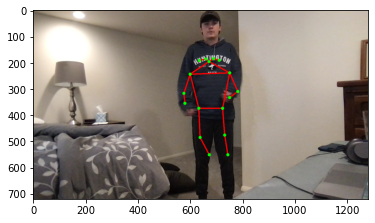

In [17]:
cap = cv2.VideoCapture(1)
vec22=[]
count3=0
while cap.isOpened():
    count3=count3+1
    ret, frame = cap.read()
    
    # Resize image to multiple of 32
    img = frame.copy()
    img = tf.image.resize_with_pad(tf.expand_dims(img, axis=0), 192,192)
    input_img = tf.cast(img, dtype=tf.int32)
    
    # Detection section
    results = movenet(input_img)
    #print(results) #This is one set of detections 
    #print(results['output_0'].numpy()[:,:,:51])
    keypoints_with_scores = results['output_0'].numpy()[:,:,:51].reshape((1,17,3))

    
    # Render keypoints 
    loop_through_people(frame, keypoints_with_scores, EDGES, 0.1)
    
    cv2.imshow('Movenet Multipose', frame)
    vec2=keypoints_with_scores[0,:,2] 
    #plt.plot(vec2,'r')
    vec22.append(vec2)
    if cv2.waitKey(1) & 0xFF==ord('q'):
        break
cap.release()
cv2.waitKey(1)
cv2.destroyAllWindows()
cv2.waitKey(1)
plt.imshow(cv2.cvtColor(frame,cv2.COLOR_BGR2RGB))

Comment on the error: As you can see in the video recording and this snipped above, there is a little bit of shifted error especially around identifying the eyes, ears, and nose. This error comes from the resizing with padding having a thrown off error. Unfortunately, this resizing is somewhat delicate, and even with making calculator computations of what we think the image ratio passed in should be, the models can quickly fail and error out. So we have kept this ratios at their documentation image ratio, however for a high-stakes job we would have spent time optimizing this ratio without erroring out the program to meet the eyes with more precision.

In [18]:
print(keypoints_with_scores)
vec2=keypoints_with_scores[0,:,2] 

[[[0.27241176 0.52507454 0.43765908]
  [0.25783968 0.5389296  0.4113708 ]
  [0.258707   0.5157387  0.6528337 ]
  [0.2661503  0.55577457 0.6278602 ]
  [0.26716867 0.49649292 0.37749067]
  [0.3323788  0.58742166 0.5324487 ]
  [0.33988577 0.46950635 0.5925453 ]
  [0.4317357  0.6115283  0.4235767 ]
  [0.44035375 0.4500711  0.49899232]
  [0.46313044 0.5870521  0.5352685 ]
  [0.49370706 0.4534619  0.5362304 ]
  [0.5201065  0.5661961  0.6521271 ]
  [0.5199083  0.49499226 0.4927896 ]
  [0.66203606 0.57256866 0.48525164]
  [0.6741606  0.49912342 0.38808423]
  [0.7653848  0.58171684 0.41273347]
  [0.76645577 0.52643377 0.26456776]]]


## Comparison between all 3 TF Models.

To compare these three pose estimation models, we will visualize their confidence metrics relative to the bodypart they are trying to estimate and see if we are noticing the same performance behaviors that are explained in Google's publications about each model.

First we have just plotted the last frame from each model to show the fact that each frame has an associated confidence for each bodypart. Throughout a live video, there will be many frames (obviously), and we will plot that analysis next. 

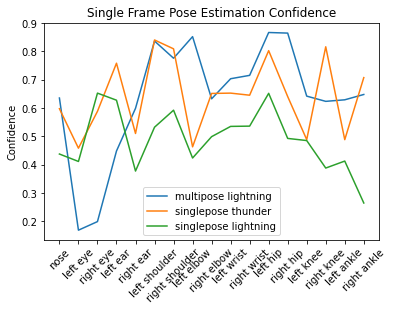

In [19]:
plt.plot(vec0, label='multipose lightning')
plt.plot(vec1, label='singlepose thunder')
plt.plot(vec2, label='singlepose lightning')
ticks = [0,1, 2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]
labels = ['nose', 'left eye', 'right eye', 'left ear', 'right ear', 'left shoulder', 'right shoulder', 'left elbow', 'right elbow','left wrist', 'right wrist', 'left hip', 'right hip', 'left knee', 'right knee', 'left ankle', 'right ankle']
plt.xticks(ticks, labels)
plt.xticks(rotation = 45)
plt.title('Single Frame Pose Estimation Confidence')
plt.ylabel('Confidence')
plt.legend()
plt.show()

We will wait to make generalized conclusions about the performance between these three models for our next comparison which shows all the frames plotted together. Keep in mind our videos for these included webcame footage of one of us basically the same distance away (but not exactly the same video) so there is some, but minimal variability. 

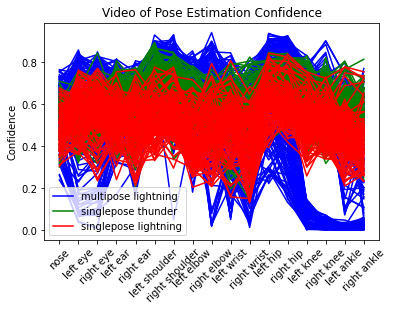

In [20]:
#Just a quick way to get the legend to say the right thing
plt.plot(np.transpose(vec00[0]),'b')
plt.plot(np.transpose(vec11[0]),'g')
plt.plot(np.transpose(vec22[0]),'r')
plt.legend(['multipose lightning','singlepose thunder','singlepose lightning'])
#Now after the first three (for the legend) I plot the rest
plt.plot(np.transpose(vec00[1:]),'b')
plt.plot(np.transpose(vec11[1:]),'g')
plt.plot(np.transpose(vec22[1:]),'r')
ticks = [0, 1, 2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]
labels = ['nose', 'left eye', 'right eye', 'left ear', 'right ear', 'left shoulder', 'right shoulder', 'left elbow', 'right elbow','left wrist', 'right wrist', 'left hip', 'right hip', 'left knee', 'right knee', 'left ankle', 'right ankle']
plt.xticks(ticks, labels)
plt.xticks(rotation = 45)
plt.title('Video of Pose Estimation Confidence')
plt.ylabel('Confidence')
plt.show()

## Conclusions
As a general statement: we have validated the hypothesis we have drawn from reading Google's published overviews of each model! In the video recording, we can notice that the lightning models (first, second, and last webcam videos) processed movement slighly faster than the thunder (the third video). However in terms of confidence, we can see that multipose lightning has the nighest fluctuations, and least amount of confidence overall with its estimations of our bodyparsts. Singlepose lightning was more confident than multipose, but slightly less confident than thunder. These are the exact conclusions made by Google and expresses the purpose behind each pose model. For future work, as we breifly discussed, we would like to combine the concepts from this biweekly report rounded out with previous concepts through this tiktok example. We would use pose estimation to develop the location and connectivity of body parts, then use optical flow strategies to measure movement (of dancing), and then classification NN (maybe compare a few) to classify which iconic tiktok dance people are doing in the video. 

## References 
* https://tfhub.dev/s?q=movenet
* https://storage.googleapis.com/movenet/MoveNet.MultiPose%20Model%20Card.pdf
* https://storage.googleapis.com/movenet/MoveNet.SinglePose%20Model%20Card.pdf
* https://www.youtube.com/watch?v=SVqmVi-3uDs
* https://www.youtube.com/watch?v=KC7nJtBHBqg
* https://arxiv.org/pdf/1801.04381.pdf
* https://arxiv.org/pdf/1612.03144.pdf
* https://arxiv.org/pdf/1904.07850.pdf